In [2]:
# Importing required Liberaries

In [3]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Settings

In [6]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [7]:
# Read Dataset

In [8]:
dataset_filename = os.listdir("D:")[0]
dataset_path = os.path.join("D:","Tweets.csv")
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: D:Tweets.csv


In [9]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [10]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
# Map target label to String

In [12]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [13]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 517 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

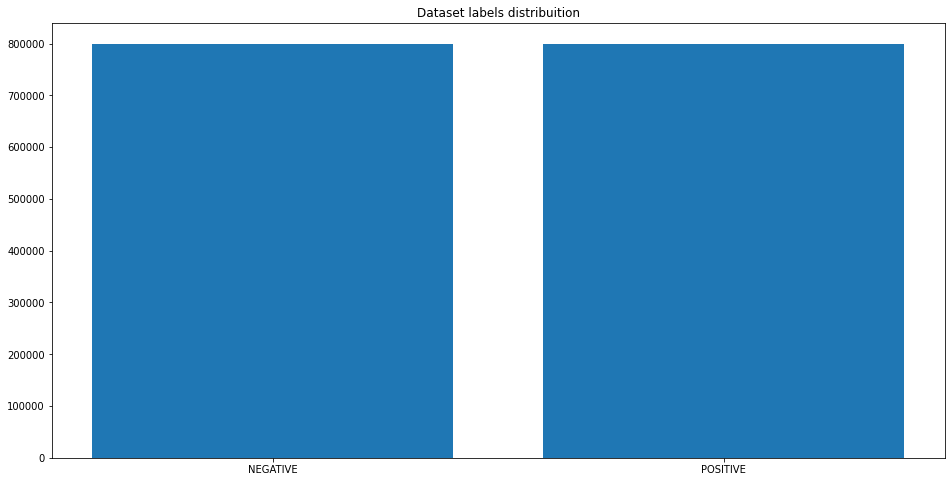

In [14]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [15]:
# Pre-Process dataset

In [16]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")


In [17]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [18]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 52.8 s


In [19]:
# Split train and test

In [20]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [21]:
# Word2Vec

In [22]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 3.63 s


In [23]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [24]:
w2v_model.build_vocab(documents)

2020-12-20 20:08:52,055 : INFO : collecting all words and their counts
2020-12-20 20:08:52,057 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-20 20:08:52,082 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-12-20 20:08:52,108 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-12-20 20:08:52,136 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-12-20 20:08:52,166 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-12-20 20:08:52,202 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-12-20 20:08:52,233 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-12-20 20:08:52,267 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-12-20 20:08:52,302 : INFO : PROGRESS: at s

2020-12-20 20:08:54,354 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-12-20 20:08:54,387 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-12-20 20:08:54,417 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-12-20 20:08:54,448 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-12-20 20:08:54,484 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-12-20 20:08:54,527 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-12-20 20:08:54,563 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-12-20 20:08:54,608 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-12-20 20:08:54,642 : INFO : PROGRESS: at sentence #800000, processed 577088

In [25]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [26]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-12-20 20:08:57,290 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-12-20 20:08:58,317 : INFO : EPOCH 1 - PROGRESS: at 8.69% examples, 707626 words/s, in_qsize 16, out_qsize 0
2020-12-20 20:08:59,320 : INFO : EPOCH 1 - PROGRESS: at 17.13% examples, 699980 words/s, in_qsize 15, out_qsize 0
2020-12-20 20:09:00,344 : INFO : EPOCH 1 - PROGRESS: at 26.67% examples, 722283 words/s, in_qsize 14, out_qsize 1
2020-12-20 20:09:01,349 : INFO : EPOCH 1 - PROGRESS: at 36.61% examples, 745465 words/s, in_qsize 14, out_qsize 1
2020-12-20 20:09:02,351 : INFO : EPOCH 1 - PROGRESS: at 46.67% examples, 761638 words/s, in_qsize 16, out_qsize 0
2020-12-20 20:09:03,355 : INFO : EPOCH 1 - PROGRESS: at 56.62% examples, 770905 words/s, in_qsize 14, out_qsize 1
2020-12-20 20:09:04,390 : INFO : EPOCH 1 - PROGRESS: at 67.45% examples, 783940 words/s, in_qsize 15, out_qsize 3
2020-12-20 20:09:05,397 : INFO : EPOCH 1 - PROGRESS: 

2020-12-20 20:09:42,906 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-20 20:09:42,908 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-20 20:09:42,910 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-20 20:09:42,922 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-20 20:09:42,925 : INFO : EPOCH 5 - PROGRESS: at 99.67% examples, 902976 words/s, in_qsize 3, out_qsize 1
2020-12-20 20:09:42,926 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-20 20:09:42,927 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-20 20:09:42,939 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-20 20:09:42,941 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-20 20:09:42,942 : INFO : EPOCH - 5 : training on 9227204 raw words (8222293 effective words) took 9.1s, 904192 effective words/s
2020-12-20 20:09:43,96

2020-12-20 20:10:22,124 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-20 20:10:22,133 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-20 20:10:22,135 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-20 20:10:22,136 : INFO : EPOCH - 9 : training on 9227204 raw words (8220932 effective words) took 9.9s, 833882 effective words/s
2020-12-20 20:10:23,162 : INFO : EPOCH 10 - PROGRESS: at 9.88% examples, 802022 words/s, in_qsize 15, out_qsize 0
2020-12-20 20:10:24,171 : INFO : EPOCH 10 - PROGRESS: at 21.90% examples, 890661 words/s, in_qsize 14, out_qsize 1
2020-12-20 20:10:25,172 : INFO : EPOCH 10 - PROGRESS: at 33.48% examples, 911130 words/s, in_qsize 15, out_qsize 0
2020-12-20 20:10:26,188 : INFO : EPOCH 10 - PROGRESS: at 45.48% examples, 926616 words/s, in_qsize 15, out_qsize 0
2020-12-20 20:10:27,199 : INFO : EPOCH 10 - PROGRESS: at 57.60% examples, 938825 words/s, in_qsize 14, out_qsize 1
2020-12-20 20:10

2020-12-20 20:11:03,911 : INFO : EPOCH 14 - PROGRESS: at 64.30% examples, 878020 words/s, in_qsize 14, out_qsize 1
2020-12-20 20:11:04,923 : INFO : EPOCH 14 - PROGRESS: at 77.53% examples, 906124 words/s, in_qsize 14, out_qsize 1
2020-12-20 20:11:05,933 : INFO : EPOCH 14 - PROGRESS: at 89.34% examples, 913045 words/s, in_qsize 13, out_qsize 2
2020-12-20 20:11:06,715 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-20 20:11:06,717 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-20 20:11:06,721 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-20 20:11:06,727 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-20 20:11:06,729 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-20 20:11:06,748 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-20 20:11:06,749 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-20 20:11:0

2020-12-20 20:11:40,758 : INFO : EPOCH - 18 : training on 9227204 raw words (8222444 effective words) took 8.2s, 998640 effective words/s
2020-12-20 20:11:41,774 : INFO : EPOCH 19 - PROGRESS: at 12.06% examples, 986336 words/s, in_qsize 16, out_qsize 0
2020-12-20 20:11:42,776 : INFO : EPOCH 19 - PROGRESS: at 25.04% examples, 1026498 words/s, in_qsize 14, out_qsize 1
2020-12-20 20:11:43,779 : INFO : EPOCH 19 - PROGRESS: at 37.59% examples, 1028014 words/s, in_qsize 15, out_qsize 1
2020-12-20 20:11:44,789 : INFO : EPOCH 19 - PROGRESS: at 50.24% examples, 1029105 words/s, in_qsize 13, out_qsize 2
2020-12-20 20:11:45,804 : INFO : EPOCH 19 - PROGRESS: at 62.58% examples, 1023317 words/s, in_qsize 15, out_qsize 0
2020-12-20 20:11:46,824 : INFO : EPOCH 19 - PROGRESS: at 74.92% examples, 1018646 words/s, in_qsize 14, out_qsize 1
2020-12-20 20:11:47,835 : INFO : EPOCH 19 - PROGRESS: at 84.91% examples, 988908 words/s, in_qsize 15, out_qsize 0
2020-12-20 20:11:48,838 : INFO : EPOCH 19 - PROGRESS

2020-12-20 20:12:21,919 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-20 20:12:21,921 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-20 20:12:21,932 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-20 20:12:21,940 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-20 20:12:21,943 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-20 20:12:21,944 : INFO : EPOCH - 23 : training on 9227204 raw words (8222399 effective words) took 7.9s, 1037239 effective words/s
2020-12-20 20:12:22,962 : INFO : EPOCH 24 - PROGRESS: at 12.49% examples, 1021750 words/s, in_qsize 15, out_qsize 0
2020-12-20 20:12:23,965 : INFO : EPOCH 24 - PROGRESS: at 24.94% examples, 1021245 words/s, in_qsize 15, out_qsize 0
2020-12-20 20:12:24,983 : INFO : EPOCH 24 - PROGRESS: at 37.92% examples, 1030784 words/s, in_qsize 14, out_qsize 1
2020-12-20 20:12:25,999 : INFO : EPOCH 24 - PROGRESS: at 5

2020-12-20 20:13:01,601 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-20 20:13:01,605 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-20 20:13:01,607 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-20 20:13:01,612 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-20 20:13:01,628 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-20 20:13:01,633 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-20 20:13:01,638 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-20 20:13:01,639 : INFO : EPOCH - 28 : training on 9227204 raw words (8223369 effective words) took 8.0s, 1029655 effective words/s
2020-12-20 20:13:02,661 : INFO : EPOCH 29 - PROGRESS: at 12.06% examples, 982289 words/s, in_qsize 14, out_qsize 1
2020-12-20 20:13:03,668 : INFO : EPOCH 29 - PROGRESS: at 24.61% examples, 1004428 words/s, in_qsize 15, out_q

Wall time: 4min 35s


(263125754, 295270528)

In [27]:
w2v_model.most_similar("love")

C:\Users\adity\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-12-20 20:13:33,288 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5760317444801331),
 ('loves', 0.5526248216629028),
 ('loved', 0.5433290004730225),
 ('adore', 0.5357129573822021),
 ('amazing', 0.4979192912578583),
 ('looove', 0.4843333959579468),
 ('awesome', 0.47363802790641785),
 ('loveee', 0.4496980309486389),
 ('lovee', 0.44459018111228943),
 ('loooove', 0.43962717056274414)]

In [28]:
# Tokenize Text

In [29]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 16 s


In [30]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 26.8 s


In [31]:
# Label Encoder

In [32]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [33]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [34]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [35]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [36]:
# Embedding layer

In [37]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [38]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [39]:
# Bulding model

In [40]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [41]:
# Compile model

In [42]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [43]:
# Callbacks

In [44]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [45]:
# Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
   4/1125 [..............................] - ETA: 1:52:50 - loss: 0.6930 - accuracy: 0.5400

In [ ]:
# Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()